In [655]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.naive_bayes import MultinomialNB, GaussianNB


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix ,classification_report, accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score

from sklearn.impute import SimpleImputer


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

import pandas_profiling

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
import plotly.tools as tls


In [656]:
df_churn = pd.read_csv('Telco-Customer-Churn.csv')

In [657]:
df_churn;

#### Dropping "CustomerID" as it provides no signal

In [658]:
df_churn.drop(['customerID'], axis=1, inplace=True)

#### Replacing empty spaces with null values in "TotalCharges"

In [659]:
df_churn['TotalCharges'] = df_churn["TotalCharges"].replace(" " , np.nan)

#### Dropping nulls from "TotalCharges" 

In [660]:
df_churn = df_churn[df_churn["TotalCharges"].notnull()]
df_churn = df_churn.reset_index()[df_churn.columns]

#### Converting strings to floats in "TotalCharges"

In [661]:
df_churn["TotalCharges"] = df_churn["TotalCharges"].astype(float)

#### replacing 'No internet service' to 'No' for columns which show 'No internet service'

Making it more consistent, logically sound

In [662]:
replace_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']

for i in replace_columns : 
    df_churn[i]  = df_churn[i].replace({'No internet service' : 'No'})

In [663]:
'''

''';
    
# #replace values
# df_churn["SeniorCitizen"] = df_churn["SeniorCitizen"].replace({1:"Yes",0:"No"})


### Function to bin tenures

I might come back to this and rebin later. Especially curious about more bins to differntiate users with less than 2 years further.

In [664]:
def bin_tenure(df_churn):
    
    '''
    helper function to be able to come back later and change bins
    '''
    
    if df_churn["tenure"] <= 12 :
        return "Tenure_0_to_12"
    elif (df_churn["tenure"] > 12) & (df_churn["tenure"] <= 24 ):
        return "Tenure_12_to_24"
    elif (df_churn["tenure"] > 24) & (df_churn["tenure"] <= 48) :
        return "Tenure_24_to_48"
    elif (df_churn["tenure"] > 48) & (df_churn["tenure"] <= 60) :
        return "Tenure_48_to_60"
    elif df_churn["tenure"] > 60 :
        return "Tenure_60+"

### binning tenure 

In [665]:
df_churn["tenure_bin"] = df_churn.apply(lambda df_churn:bin_tenure(df_churn), axis = 1)

In [666]:
# cat_cols   = df_churn.nunique()[df_churn.nunique() <= 5].keys().tolist()
# cat_cols;

In [667]:
# Separating churn and non-churn
df_only_churn     = df_churn[df_churn["Churn"] == "Yes"]
df_not_churn = df_churn[df_churn["Churn"] == "No"]

# Separating columns by numerical and categorical, target column is "Churn"
target_col = ["Churn"]

cat_cols   = df_churn.nunique()
cat_cols   = df_churn.nunique()[df_churn.nunique() <= 5].keys().tolist()
cat_cols   = [col for col in cat_cols if col not in target_col]
num_cols   = [col for col in df_churn.columns if col not in cat_cols + target_col]


# get binary columns with 2 values
bin_cols   = df_churn.nunique()[df_churn.nunique() == 2].keys().tolist()
# get columns with more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

In [668]:
df_churn;

In [669]:

# df_scaled.to_pickle("./df_churn.pkl")


In [670]:
# df_churn_scaled = df_churn.drop(columns = num_cols,axis = 1)
# df_churn_scaled = df_churn_scaled.merge(df_scaled,left_index=True,right_index=True,how = "left")

In [671]:
df_churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Tenure_0_to_12
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Tenure_24_to_48
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Tenure_0_to_12
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Tenure_24_to_48
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Tenure_0_to_12


### One Hot Encoding

In [672]:
df_churn_encoded = pd.get_dummies(data = df_churn,columns = multi_cols, drop_first = True )


In [673]:
df_churn_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_bin_Tenure_12_to_24,tenure_bin_Tenure_24_to_48,tenure_bin_Tenure_48_to_60,tenure_bin_Tenure_60+
0,Female,0,Yes,No,1,No,No,Yes,No,No,...,0,0,0,0,1,0,0,0,0,0
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,...,0,1,0,0,0,1,0,1,0,0
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,...,0,0,0,0,0,1,0,0,0,0
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,...,0,1,0,0,0,0,0,1,0,0
4,Female,0,No,No,2,Yes,No,No,No,No,...,0,0,0,0,1,0,0,0,0,0


In [674]:
df_churn_encoded = pd.get_dummies(data = df_churn_encoded,columns = bin_cols, drop_first = True )

In [675]:
df_churn_encoded.head();

In [676]:
df_churn_encoded.head();

In [677]:

# df_churn_scaled.to_pickle("./df_churn_scaled_with_1_hot_encoding.pkl")


In [678]:
# df_churn_scaled = pd.read_pickle("./df_churn_scaled_with_1_hot_encoding.pkl")

In [679]:
df_churn_encoded.head();
df_churn_encoded.isnull().values.any();

## Model

### Train Test Validation Split

In [693]:
train_val , test = train_test_split(df_churn_encoded,test_size = .20 ,random_state = 1988)
train , val = train_test_split(train_val, test_size = .20 ,random_state = 2014)

In [710]:
target_col = ["Churn_Yes"]

cols    = [i for i in df_churn_encoded.columns if i not in target_col]

'''
train_val_X and _Y are used for cross validation.

train_X is a subset of train_val_X

test_X and test_Y are the holdout sets


'''

train_val_X = train_val[cols]
train_val_Y = train_val[target_col]
train_X = train[cols]
train_Y = train[target_col]
val_X = val[cols]
val_Y = val[target_col]
test_X  = test[cols]
test_Y  = test[target_col]


In [720]:
train_val_X.head();

### Standardizing
Standardizing the columns with numerical data, i.e. 'tenure', 'MonthlyCharges', 'TotalCharges'

In [704]:
std = StandardScaler()


In [701]:
std.fit(train_val_X[num_cols])
test_X[num_cols] = std.transform(test_X[num_cols])
train_val_X[num_cols] = std.transform(train_val_X[num_cols])


In [707]:
std.fit(train_X[num_cols])
val_X[num_cols] = std.transform(val_X[num_cols])
train_X[num_cols] = std.transform(train_X[num_cols])

#### Function to show ROC

In [259]:
def plot_roc(test_y, preds, probs):
    '''
    plots ROC and prints out AUC
    '''
    model_roc_auc = roc_auc_score(test_y, preds) 
    print ("Area under curve : ",model_roc_auc,"\n")

    fpr, tpr, thresholds = roc_curve(test_y, probs[:,1])

    plt.plot(fpr, tpr, lw = 2)
    plt.plot([0,1],[0,1], c='violet', ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve');

#### Function to make predictions and return ROC AUC

In [260]:
def get_model_ROC_AUC(algorithm, test_x, test_y):
    '''
    Input is a model that has been .fit(), and the dfs for test_x and test_y
    
    returns ROC AUC
    '''
    
    predictions   = algorithm.predict(test_x)
    probabilities = algorithm.predict_proba(test_x)
    model_roc_auc = roc_auc_score(test_y, predictions)
    return model_roc_auc

#### Function to compare baseline models

In [297]:
def get_baseline_models_AUCs(train_x = train_X, test_x = val_X,
                            train_y = train_Y, test_y = val_Y):
    '''
    This function prints out the AUCs for all baseline models.
    It returns a dict with all the models as keys, and the AUCs as values.
    '''
    result = {}
    models = {"Logistic Regression" : LogisticRegression(), 
              "KNN" : KNeighborsClassifier(n_neighbors = 6),
              "Support Vector Classifier" : SVC(probability=True),
              "Random Forest": RandomForestClassifier(random_state= 31),
              "Gaussian Naive Bayes" : GaussianNB(),
#               "Multinomial Naive Bayes" : MultinomialNB(),
              "Gradient Boost Classifier" : GradientBoostingClassifier(),
              "Light GBM Classifier" : LGBMClassifier(),
              "XGBoost Classifier" : XGBClassifier()
              
             }
    
    for key, algorithm in models.items():
        fit_model = algorithm.fit(train_x, train_y)
        model_roc_auc = get_model_ROC_AUC(fit_model, test_x, test_y)
        print (f'{key} :  {model_roc_auc}\n')
        result[key] = model_roc_auc
    
    return result

In [335]:
get_baseline_models_AUCs()

Logistic Regression :  0.701724124594881

KNN :  0.6520269486320707

Support Vector Classifier :  0.6595221336138549

Random Forest :  0.6411805883217438

Gaussian Naive Bayes :  0.7630121516363327

Gradient Boost Classifier :  0.6955129444706574

Light GBM Classifier :  0.688048699364959

XGBoost Classifier :  0.6961433444459055



{'Logistic Regression': 0.701724124594881,
 'KNN': 0.6520269486320707,
 'Support Vector Classifier': 0.6595221336138549,
 'Random Forest': 0.6411805883217438,
 'Gaussian Naive Bayes': 0.7630121516363327,
 'Gradient Boost Classifier': 0.6955129444706574,
 'Light GBM Classifier': 0.688048699364959,
 'XGBoost Classifier': 0.6961433444459055}

### Correlation Matrix

In [291]:
def make_correlation_matrix(df = df_churn):   
    '''
    produces a plotly correlation matrix
    
    INPUT: dataframe
    
    RETURNS: the plotly plot.
    
    NOTE: you need to store the output of this function in a cariable, 
    and then put that in a new line to see the plot.
    like so:

    out = make_correlation_matrix(df_churn_scaled)
    out
    
    '''
    correlations = df.corr()
    matrix_columns = correlations.columns.tolist()
    corr_array  = np.array(correlations)

    
    heat = go.Heatmap(z = corr_array,
                        x = matrix_columns,
                        y = matrix_columns,
                        colorscale = "Jet",
                        colorbar   = dict(title = "Pearson correlation coefficient",
                                         titleside = "right"
                                        ) ,
                      )

    layout = go.Layout(dict(title = "Correlation Matrix",
                            
                            height  = 600,
                            width   = 800,
                            margin  = dict(r = 0 ,l = 200,
                                           t = 25,b = 200,
                                          ),
                            yaxis   = dict(tickfont = dict(size = 10)),
                            xaxis   = dict(tickfont = dict(size = 10))
                           )
                      )

    fig = go.Figure(data= [heat],layout=layout)
    return py.iplot(fig, filename = 'correlation-matrix')

In [721]:
out = make_correlation_matrix(df_churn_scaled)
out

## Model Pipeline

In [287]:
def make_model_prediction_coefs(cols, cf, algorithm = LogisticRegression(), 
                                train_x = train_X , test_x = val_X ,
                                train_y = train_Y ,test_y = val_Y ) :
    
    '''
    This function fits the model, prints a summary including AUC curve, accuracy score, F1 score
    It also produces 3 plotly graphs: A confusion matrix, an ROC curve, and a bar graph showing
    feature importance for each feature.
    
    INPUT:
    It takes columns, algorithm, train_df for x and y, test_df for x and y bas inputs
    
    cf is an input string that is either "coefficients" or "features"
    
    RETURNS: A tuple of (model, pyplot object)
    
    DEFAULT:
    Its default algorithm is LogisticRegression()
    default train dfs are train_X and train_Y
    default test dfs are val_X and val_Y
    
    NOTE: you need to store the output of this function in a variable, 
    and then put that in a new line to see the plot.
    like so:
    
    (logit_model, logit_graph) = make_model_prediction_coefs(cols = cols, cf = "coefficients")
    logit_graph
    '''
    
    
    algorithm.fit(train_x, train_y)
    
    predictions   = algorithm.predict(test_x)  
    probabilities = algorithm.predict_proba(test_x)

    fpr, tpr, thresholds = roc_curve(test_y, probabilities[:,1])
    
    if   cf == "coefficients":
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features":
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df       = pd.DataFrame(cols)
    coef_summary    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_summary.columns = ["coefficients","features"]
    coef_summary    = coef_summary.sort_values(by = "coefficients",ascending = False)
    
    print("_____________________________________________________________")   
    print("\n Results : \n", classification_report(test_y,predictions))
    print("Accuracy - score : ", accuracy_score(test_y,predictions))
    
    
    conf_matrix = confusion_matrix(test_y,predictions)
    
    

    # making roc curve, redundant
#     plot_roc(test_y, preds = predictions, probs = probabilities)
    
    # this can be commented out if using non-plotly roc curve above: plot_roc()
    
    model_roc_auc = roc_auc_score(test_y, predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'),
                            print_grid=False)
    
    
    
    bars = go.Bar(x = coef_summary["features"], y = coef_summary["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_summary["coefficients"],
                                  colorscale = "Jet",
                                  line = dict(width = .6, color = "black")))
    
    roc_line = go.Scatter(x = fpr, y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(25, 96, 167)'),width = 2))
    
    roc_stand = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(215, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    c_matrix = go.Heatmap(z = conf_matrix ,
                        x = ["Non churn","Churn"],
                        y = ["Non churn","Churn"],
                        showscale  = False, colorscale = "Jet",
                        name = "matrix")
    
    
    
    
    fig.append_trace(bars,2,1)
    fig.append_trace(roc_line,1,2)
    fig.append_trace(c_matrix,1,1)
    fig.append_trace(roc_stand,1,2)
    
    fig['layout'].update(showlegend = False, title="Model performance" ,
                         autosize = False,height = 1000,width = 850,
                         plot_bgcolor = 'rgba(250,250,250, 0.95)',
                         paper_bgcolor = 'rgba(250,250,250, 0.95)',
                         margin = dict(b = 185))
    
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis1"].update(dict(showgrid = True,tickfont = dict(size = 12),
                                        tickangle = 0))
#     print('\nConfusion Matrix:')
#     print(conf_matrix)
    
    
    return(algorithm, py.iplot(fig, filename = 'jupyter-table1'))


In [288]:
(logit_model, logit_graph) = make_model_prediction_coefs(cols = cols, cf = "coefficients")
logit_graph

_____________________________________________________________

 Results : 
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       803
           1       0.65      0.52      0.57       322

   micro avg       0.78      0.78      0.78      1125
   macro avg       0.73      0.70      0.71      1125
weighted avg       0.77      0.78      0.77      1125

Accuracy - score :  0.7813333333333333
Area under curve :  0.701724124594881 



## KNN

In [722]:
knn = KNeighborsClassifier(algorithm = 'auto', leaf_size=30,
           metric_params = None, n_jobs=-1, n_neighbors = 6, p = 2,
           weights='uniform')

In [723]:
knn.fit(train_X,train_Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=6, p=2,
           weights='uniform')

In [724]:
predictions_knn   = knn.predict(val_X)
probabilities_knn = knn.predict_proba(val_X)

In [725]:
print("\n Classification report: \n",classification_report(val_Y ,predictions_knn))
print("Accuracy Score: ",accuracy_score(val_Y ,predictions_knn))


 Classification report: 
               precision    recall  f1-score   support

           0       0.78      0.93      0.84       803
           1       0.64      0.33      0.44       322

   micro avg       0.76      0.76      0.76      1125
   macro avg       0.71      0.63      0.64      1125
weighted avg       0.74      0.76      0.73      1125

Accuracy Score:  0.7564444444444445


Area under curve :  0.6294118329556091 



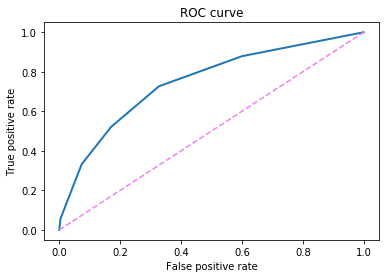

In [728]:
plot_roc(test_y = val_Y, preds = predictions_knn, probs = probabilities_knn)

## Random Forest

In [ ]:
forest = RandomForestClassifier()

## SMOTE

In [712]:
train_X_SMOTE, train_Y_SMOTE = SMOTE(random_state = 1911).fit_sample(train_X, train_Y)
train_val_X_SMOTE, train_val_Y_SMOTE = SMOTE(random_state = 1911).fit_sample(train_val_X, train_val_Y)
val_X_SMOTE, val_Y_SMOTE = SMOTE(random_state = 1911).fit_sample(val_X, val_Y)

In [713]:
(logit_model_smote, logit_graph_smote) = make_model_prediction_coefs(cols = cols, cf = "coefficients", 
                                                                     train_x =train_X_SMOTE, train_y = train_Y_SMOTE, 
                                                                     test_x = val_X_SMOTE, test_y = val_Y_SMOTE)
logit_graph_smote

_____________________________________________________________

 Results : 
               precision    recall  f1-score   support

           0       0.79      0.72      0.75       803
           1       0.74      0.81      0.78       803

   micro avg       0.77      0.77      0.77      1606
   macro avg       0.77      0.77      0.76      1606
weighted avg       0.77      0.77      0.76      1606

Accuracy - score :  0.7652552926525529
Area under curve :  0.765255292652553 



In [714]:
get_baseline_models_AUCs(train_x = train_X_SMOTE, test_x = val_X_SMOTE,
                            train_y = train_Y_SMOTE, test_y = val_Y_SMOTE)

Logistic Regression :  0.765255292652553

KNN :  0.6930261519302615

Support Vector Classifier :  0.6488169364881694

Random Forest :  0.8212951432129514

Gaussian Naive Bayes :  0.7889165628891656

Gradient Boost Classifier :  0.8449564134495641

Light GBM Classifier :  0.8306351183063513

XGBoost Classifier :  0.8480697384806973



{'Logistic Regression': 0.765255292652553,
 'KNN': 0.6930261519302615,
 'Support Vector Classifier': 0.6488169364881694,
 'Random Forest': 0.8212951432129514,
 'Gaussian Naive Bayes': 0.7889165628891656,
 'Gradient Boost Classifier': 0.8449564134495641,
 'Light GBM Classifier': 0.8306351183063513,
 'XGBoost Classifier': 0.8480697384806973}

SMOTE lead to an increased performance. 

## ADASYN

In [715]:
train_X_ADASYN, train_Y_ADASYN = ADASYN(random_state = 1911).fit_sample(train_X, train_Y)
train_val_X_ADASYN, train_val_Y_ADASYN = ADASYN(random_state = 1911).fit_sample(train_val_X, train_val_Y)
val_X_ADASYN, val_Y_ADASYN = ADASYN(random_state = 1911).fit_sample(val_X, val_Y)

In [716]:
(logit_model_adasyn, logit_graph_adasyn) = make_model_prediction_coefs(cols = cols, cf = "coefficients", 
                                                                     train_x =train_X_ADASYN, train_y = train_Y_ADASYN, 
                                                                     test_x = val_X_ADASYN, test_y = val_Y_ADASYN)
logit_graph_adasyn

_____________________________________________________________

 Results : 
               precision    recall  f1-score   support

           0       0.78      0.67      0.72       803
           1       0.72      0.82      0.77       850

   micro avg       0.75      0.75      0.75      1653
   macro avg       0.75      0.75      0.75      1653
weighted avg       0.75      0.75      0.75      1653

Accuracy - score :  0.7477313974591652
Area under curve :  0.7455475789319465 



In [717]:
get_baseline_models_AUCs(train_x = train_X_ADASYN, test_x = val_X_ADASYN,
                            train_y = train_Y_ADASYN, test_y = val_Y_ADASYN)

Logistic Regression :  0.7455475789319465

KNN :  0.6702476009083583

Support Vector Classifier :  0.6427609698923156

Random Forest :  0.8129243278880668

Gaussian Naive Bayes :  0.7698344443630504

Gradient Boost Classifier :  0.8485656728444801

Light GBM Classifier :  0.8342758772251118

XGBoost Classifier :  0.847285913119918



{'Logistic Regression': 0.7455475789319465,
 'KNN': 0.6702476009083583,
 'Support Vector Classifier': 0.6427609698923156,
 'Random Forest': 0.8129243278880668,
 'Gaussian Naive Bayes': 0.7698344443630504,
 'Gradient Boost Classifier': 0.8485656728444801,
 'Light GBM Classifier': 0.8342758772251118,
 'XGBoost Classifier': 0.847285913119918}

ADASYN does a tiny bit better than SMOTE.

### Grid Search

In [302]:
parameter_grid={
    "loss":["deviance"],
    "learning_rate": [0.05, 0.075, 0.1],
    "min_samples_split": np.linspace(0.01, 0.1, 6),
    "min_samples_leaf": np.linspace(0.1, 0.5, 6),
    "max_depth":[10,20],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[ 1.0],
    "n_estimators":[125]
    }
clf = GridSearchCV(GradientBoostingClassifier(), parameter_grid, cv=5, n_jobs=-1,scoring = 'roc_auc', verbose= True)
clf.fit(train_X_SMOTE, train_Y_SMOTE)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 91.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'loss': ['deviance'], 'learning_rate': [0.05, 0.075, 0.1], 'min_samples_split': array([0.01 , 0.028, 0.046, 0.064, 0.082, 0.1  ]), 'min_samples_leaf': array([0.1 , 0.18, 0.26, 0.34, 0.42, 0.5 ]), 'max_depth': [10, 20], 'max_features': ['sqrt'], 'criterion': ['friedman_mse', 'mae'], 'subsample': [1.0], 'n_estimators': [125]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [303]:
# clf.best_score_

0.9045428039465869

ROC_AUC is 0.9045428039465869

In [305]:
# clf_best_params = clf.best_params_

In [306]:
# clf_best_params

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.082,
 'n_estimators': 125,
 'subsample': 1.0}

GradientBoostClassifier() performs best at

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.082,
 'n_estimators': 125,
 'subsample': 1.0}


### Grid Search V2

In [ ]:
ameter_grid={
    "loss":["deviance"],
    "learning_rate": [0.05, 0.075, 0.1],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    "max_depth":[40,50],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[ 1.0],
    "n_estimators":[125]
    }
clf = GridSearchCV(GradientBoostingClassifier(), parameter_grid, cv=5, n_jobs=-1,scoring = 'roc_auc', verbose= True)

clf.fit(X_train, y_train)

### Grid Search for XGBoost 

In [336]:
params_xgboost = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [337]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=125, objective='binary:logistic',
                    silent=True, nthread=1)

In [341]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 1001)

In [718]:
random_search = RandomizedSearchCV(xgb, param_distributions = params_xgboost, 
                                   n_iter = param_comb, scoring = 'roc_auc', 
                                   n_jobs = -1, cv = skf.split(train_val_X, test_X), verbose=3, 
                                   random_state = 2000 )

In [719]:
random_search

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x1a27fa3840>,
          error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=125,
       n_jobs=1, nthread=1, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=5, n_jobs=-1,
          param_distributions={'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]},
          pre_dispatch='2*n_jobs', random_state=2000, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=3)